- Para este terceiro ciclo, iremos levar em consideração o desbalanceamento da nossa target feature. Como visto nos ciclos anteriores, o desbalanceamento nos dados pode afetar negativamente o nosso modelo. Aqui utilizaremos a biblioteca imbalance-learn para balancear nosso dataset.

- Após testar tanto o UnderSampling como o OverSampling, otive o melhor ganho com o OverSampling. Além disso, o melhor modelo passou a ser a random forest, em vez da regressão logística. Portanto, iremos utilizá-lo no hyperparameter tunning, para melhorar ainda mais sua performance.

De Regressão Logística para Random Forest:
- Acurácia de 79,1% para 89,5%
- Precisão de 65,4% para 85,4%
- Recall de 45,4% para 95,3%
- F1 de 53,6% para 90,1%

# 1 IMPORTS

In [1]:
import inflection
import numpy                   as np
import pandas                  as pd
import seaborn                 as sns
import scikitplot              as skplt
import matplotlib.pyplot       as plt
import sklearn.preprocessing   as pp
import sklearn.model_selection as ms

from sklearn                   import metrics
from sklearn.svm               import SVC
from tabulate                  import tabulate
from IPython.display           import Image
from sklearn                   import ensemble as en
from sklearn.pipeline          import Pipeline
from sklearn.dummy             import DummyClassifier
from pandas_profiling          import ProfileReport
from sklearn.model_selection   import GridSearchCV
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.linear_model      import LogisticRegression
from imblearn.over_sampling    import RandomOverSampler
from imblearn.under_sampling   import RandomUnderSampler
from pycorrcat.pycorrcat       import plot_corr, corr_matrix
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier


## 1.1 Definitions 

In [2]:
np.random.seed(seed=42)

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

def model_metrics(y_true, y_hat, model_name):
    accuracy = metrics.accuracy_score(y_true, y_hat)
    recall = metrics.recall_score(y_true, y_hat)
    precision = metrics.precision_score(y_true, y_hat)
    f1 = metrics.f1_score(y_true, y_hat)
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'Accuracy': accuracy, 
                           'Recall': recall,
                           'Precision': precision,
                           'F1': f1}, index=[0] )

def model_metrics_cv(model, X, y, cv, model_name):
    results = ms.cross_validate(pipeline, X, y, cv=cv, 
                                scoring=['accuracy', 'f1', 'precision', 'recall'])
    accuracy = str(np.round(results['test_accuracy'].mean(),3)) + '+/-' + str(2 * np.round(results['test_accuracy'].std(),3))
    recall = str(np.round(results['test_recall'].mean(),3)) + '+/-' + str(2 * np.round(results['test_recall'].std(),3))
    precision = str(np.round(results['test_precision'].mean(),3)) + '+/-' + str(2 * np.round(results['test_precision'].std(),3))
    f1 = str(np.round(results['test_f1'].mean(),3)) + '+/-' + str(2 * np.round(results['test_f1'].std(),3))
    return pd.DataFrame( { 'Model Name': model_name, 
                           'Accuracy': accuracy, 
                           'Recall': recall,
                           'Precision': precision,
                           'F1': f1}, index=[0] )



## 1.2 Loading Data

In [3]:
# coletando os dados e salvando localmente
url = 'https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json'
df_raw = pd.read_json(url)
df_raw.to_json('../data/customers.json')


# 2 DATA DESCRIPTION

## 2.1 Data Preview

Após a importação dos dados, verificamos que há informações aninhadas em formato json. Portanto, para acessar esses dados e termos o nosso dataframe definitivo, utilizaremos ferramentas que serão mostradas nas próximas sessões.

In [4]:
df_raw.head(3)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 2.2 Data Format and Types

In [5]:
# coletando informacoes dos jsons
columns = ['customer', 'phone', 'internet', 'account']
for column in columns:
    df_temp = pd.json_normalize(data=df_raw[column], sep='_')
    df_raw = pd.concat([df_raw, df_temp], axis=1)

# removendo colunas duplicadas
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]

# padronizando os headers para snake case
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# removendo as colunas com os formatos json
df_raw.drop(columns=['customer', 'phone', 'internet', 'account'],inplace=True)

# transformando valores vazios e ausentes em NA
df_raw = df_raw.mask(df_raw == ' ').mask(df_raw == '')


In [6]:
# removendo 11 linhas que estão com valores vazios em charges_total para converter em float
df_raw.dropna(subset=['charges_total'], inplace=True)
df_raw['charges_total'] = df_raw['charges_total'].astype('float')

In [7]:
df_raw.head(3)

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,charges_monthly,charges_total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7256 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7256 non-null   object 
 1   churn              7032 non-null   object 
 2   gender             7256 non-null   object 
 3   senior_citizen     7256 non-null   int64  
 4   partner            7256 non-null   object 
 5   dependents         7256 non-null   object 
 6   tenure             7256 non-null   int64  
 7   phone_service      7256 non-null   object 
 8   multiple_lines     7256 non-null   object 
 9   internet_service   7256 non-null   object 
 10  online_security    7256 non-null   object 
 11  online_backup      7256 non-null   object 
 12  device_protection  7256 non-null   object 
 13  tech_support       7256 non-null   object 
 14  streaming_tv       7256 non-null   object 
 15  streaming_movies   7256 non-null   object 
 16  contract           7256 

## 2.3 NA Checking and Treatment

Agora que conseguimos ter acesso às informações dos jsons aninhados, faremos o tratamento de valores nulos/faltantes.

In [9]:
df_raw.isna().sum()

customer_id            0
churn                224
gender                 0
senior_citizen         0
partner                0
dependents             0
tenure                 0
phone_service          0
multiple_lines         0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
contract               0
paperless_billing      0
payment_method         0
charges_monthly        0
charges_total          0
dtype: int64

In [10]:
# deletando as linhas com valores nulos em churn. Como é nossa variável resposta, não
# temos como inferir valores.
df_raw.dropna(inplace=True)

In [11]:
df_raw.isna().sum()

customer_id          0
churn                0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
charges_monthly      0
charges_total        0
dtype: int64

## 2.4 Discriptive Statistics

Nesta seção faremos uma rápida análise estatística para identificar se temos valores que precisam de uma maior atenção (valores negativos, outliers, erros de digitação, etc).

### Numerical Attributes

In [12]:
num_att = df_raw.select_dtypes(['int64', 'float64'])
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = df_raw.describe().round(2)
m = pd.concat([describe, skew, kurtosis], axis=0)
m

,senior_citizen,tenure,charges_monthly,charges_total
count,7032.00,7032.00,7032.00,7032.00
mean,0.16,32.42,64.80,2283.30
std,0.37,24.55,30.09,2266.77
min,0.00,1.00,18.25,18.80
25%,0.00,9.00,35.59,401.45
50%,0.00,29.00,70.35,1397.48
75%,0.00,55.00,89.86,3794.74
max,1.00,72.00,118.75,8684.80
skew,1.83,0.24,-0.22,0.96
kurtosis,1.35,-1.39,-1.26,-0.23


### Categorical Attributes

Observamos nesta seção que temos muitas variáveis categóricas com uma baixa quantidade de valores únicos. Nos próximos snippets iremos observar a possibilidade de simplificar estas features.

In [13]:
cat_att = df_raw.select_dtypes(exclude=['int64', 'float64'])
cat_att.apply( lambda x: x.unique().shape[0] )

customer_id          7032
churn                   2
gender                  2
partner                 2
dependents              2
phone_service           2
multiple_lines          3
internet_service        3
online_security         3
online_backup           3
device_protection       3
tech_support            3
streaming_tv            3
streaming_movies        3
contract                3
paperless_billing       2
payment_method          4
dtype: int64

In [14]:
for column in df_raw.columns:
    print(column, ': ',df_raw[column].unique())

customer_id :  ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
churn :  ['No' 'Yes']
gender :  ['Female' 'Male']
senior_citizen :  [0 1]
partner :  ['Yes' 'No']
dependents :  ['Yes' 'No']
tenure :  [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
phone_service :  ['Yes' 'No']
multiple_lines :  ['No' 'Yes' 'No phone service']
internet_service :  ['DSL' 'Fiber optic' 'No']
online_security :  ['No' 'Yes' 'No internet service']
online_backup :  ['Yes' 'No' 'No internet service']
device_protection :  ['No' 'Yes' 'No internet service']
tech_support :  ['Yes' 'No' 'No internet service']
streaming_tv :  ['Yes' 'No' 'No internet service']
streaming_movies :  ['No' 'Yes' 'No internet service']
contract :  ['One year' 'Month-to-month' 'Two year']
paperless_billing :  ['Yes' 'No']
payment_meth

Para as features numéricas, não identificamos valores discrepantes ou possivelmente errados. Porém, para as features categóricas, observamos que algumas features apresentam valores redundantes ('No' e 'No xxxx service'). Para esse primeiro ciclo CRISP-DM/DS, iremos considerar que esses dois valores transmitem a mesma informação e iremos padronizá-los na seção 5.

# 3 DATAFRAME FILTERING

In [15]:
df_clean = df_raw.copy()

## 3.1 Line Filtering

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

## 4.1 Entendimento do negócio

Nesta seção iremos entender um pouco sobre o negócio, descobrindo as métricas que norteiam o ramo de telecomunicações. Também iremos formular hipóteses para posteriormente, na seção 6.2, confirmar ou não as hipóteses levantadas, gerando também insights importantes para a empresa.

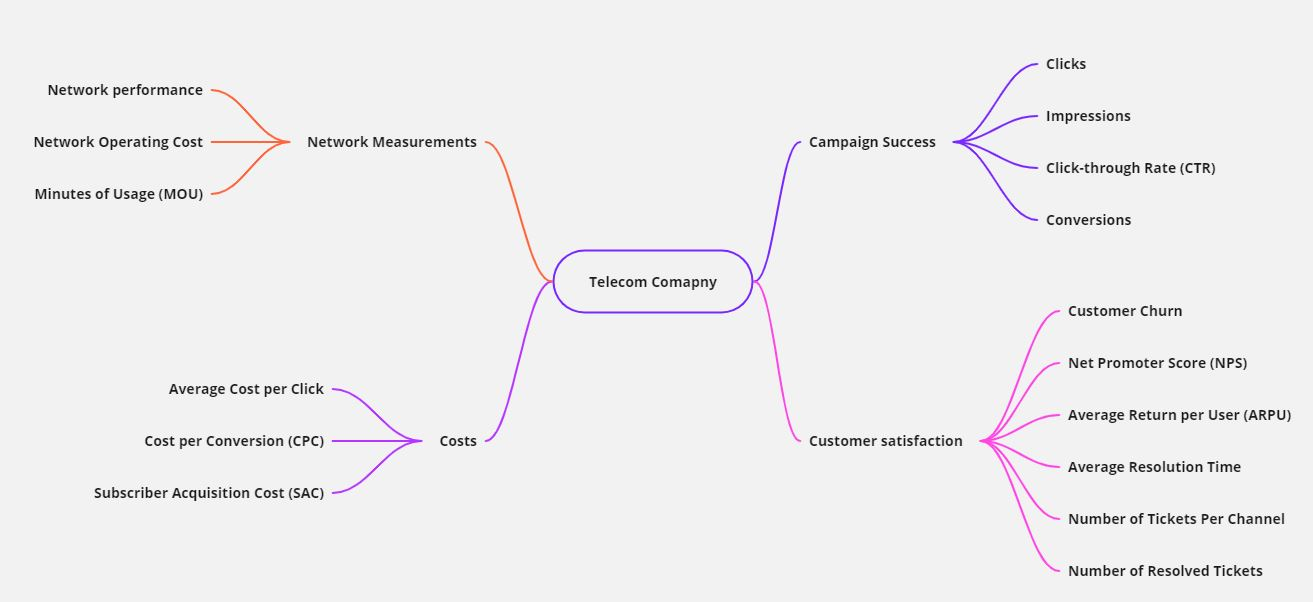

In [16]:
Image( '../images/metrics.JPG' )

Algumas métricas do ramo de telecomunicações:

- **Clicks:** Medir quantos clientes clicam em um CTA em uma determinada página da web, um link de e-mail ou um anúncio digital ainda é uma das melhores maneiras de ter uma ideia do sucesso de uma campanha de marketing

- **Impressions:** Impressões referem-se à frequência com que seu anúncio foi exibido em uma determinada plataforma, canal ou rede de publicidade.

- **Average Cost per Click:** Custo total de seus cliques pelo número total de cliques

- **Cost per Conversion (CPC):** O custo total pago por um anúncio em relação ao sucesso em atingir o objetivo desse anúncio

- **Click-through Rate (CTR):** A CTR é um KPI relacionado a cliques e impressões, traduzindo cliques em tendências, em vez de deixá-los como números agregados.

- **Conversions:** As conversões se baseiam em cliques e CTRs, exigindo que os usuários ajam assim que interagirem com seu anúncio

- **Customer Churn**

- **Network performance:** Medem fatores como disponibilidade de rede, acessibilidade, capacidade e utilização, velocidade e taxa de transferência.

- **Network Operating Cost:** Infraestrutura para manter, e muitas coisas podem aumentar seu custo, incluindo atualizações de TI, manutenção de aplicativos, segurança, suporte técnico ao cliente, cobre, fibra, micro-ondas e assim por diante.

- **Net Promoter Score (NPS):** Mede a probabilidade de um cliente recomendar sua empresa para familiares, amigos ou colegas.

- **Average Resolution Time:** É o tempo médio que os agentes de suporte levam para resolver todos os tickets abertos em um período de tempo definido.

- **Number of Tickets Per Channel:** Medidas suportam o volume de tickets ao longo do tempo

- **Number of Resolved Tickets:** Quantos tickets um agente ou equipe de atendimento ao cliente resolveu dentro de um prazo definido

- **Average revenue per user (ARPU):** Mede a receita média que uma empresa gera por usuário em um determinado período.

- **Minutes of Usage (MOU):** É o tempo total em minutos, usado por um cliente em seu celular, dentro de um determinado período de tempo.

- **Subscriber Acquisition Cost (SAC):** É uma medida usada para descobrir o custo médio total de adicionar um novo assinante à lista.


## 4.2 Hipóteses

Após o entendimento das métricas do negócio, iremos utilizar o nosso dataset para responder as hipóteses que seguem:

**1.** Quanto mais tempo de contrato o cliente tiver, menor a taxa de churn.

**2.** Mulheres tem maior probabilidade de entrar em churn.

**3.** Clientes com dependentes tendem a ter menor taxa de churn

**4.** Quanto maior o tempo de contrato, menor a taxa de churn

**5.** A maioria dos clientes que entraram em churn não tinham suporte técnico

**6.** O meio de recebimento da fatura não tem influência na taxa de churn

**7.** Clientes que tem assinatura de tv a cabo tem menores taxas de churn

**8.** Clientes com gasto diário de mais de $3 tendem a ter maior taxa de churn


# 5 FEATURE ENGINEERING

In [17]:
# ------- CONFERIR A EFETIVIDADE DESSA MODIFICAÇÃO NOS PRÓXIMOS CICLOS --------
# transformando os valores "no xxxx service em no"
for column in df_clean.columns[8:16]:
    df_clean.loc[:,column] = df_clean[column].apply(lambda x: 0 if 'No' in x else 1)
# -----------------------------------------------------------------------------

# transformando a variável churn em int
df_clean.loc[:,'churn'] = df_clean['churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável partner em int
df_clean.loc[:,'partner'] = df_clean['partner'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável dependents em int
df_clean.loc[:,'dependents'] = df_clean['dependents'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável phone_service em int
df_clean.loc[:,'phone_service'] = df_clean['phone_service'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável paperless_billing em int
df_clean.loc[:,'paperless_billing'] = df_clean['paperless_billing'].apply(lambda x: 1 if x == 'Yes' else 0)

# criando feature de gasto diário partindo do charges_total
df_clean.insert(loc=18, column='daily_charge', value=df_clean['charges_total']/(df_clean['tenure']*30))

# transformando os valores das features para o formato snake_case
df_clean.loc[:,'contract'] = df_clean['contract'].apply(lambda x: inflection.underscore(x))
df_clean.loc[:,'contract'] = df_clean['contract'].apply(lambda x: inflection.parameterize(x, separator='_'))
df_clean.loc[:,'gender'] = df_clean['gender'].apply(lambda x: inflection.parameterize(x, separator='_'))
df_clean.loc[:,'payment_method'] = df_clean['payment_method'].apply(lambda x: inflection.parameterize(x, separator='_'))


# 6 EXPLORATORY DATA ANALYSIS

Como temos muitas features, utilizei o pandas profiling para gerar um relatório estatístico de maneira mais prática e rápida, para análise.

In [18]:
# utilizando o profile report para salvar as análises univariadas em html
profile = ProfileReport( df_clean )
profile.to_file( '../general_statistics.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 6.1 Univariate Analysis

### 6.1.1 Response Variable

Como mostrado no histograma abaixo, observamos que há um desbalanceamento na variável resposta. Em algoritmos de classificação, este é um ponto importante a ser observado, pois pode influenciar negativamente o desempenho do nosso modelo.

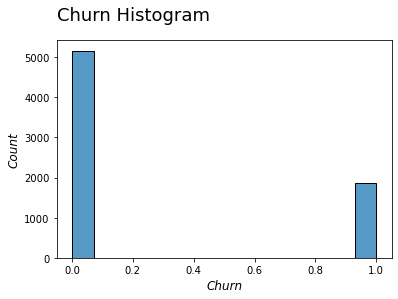

In [19]:
ax1 = sns.histplot(data=df_clean, x='churn')
std_font(ax1, 'Churn Histogram', 'Churn', 'Count')

### 6.1.2 Numerical Variable

In [20]:
num_att = df_clean.select_dtypes(['int64', 'float64'])

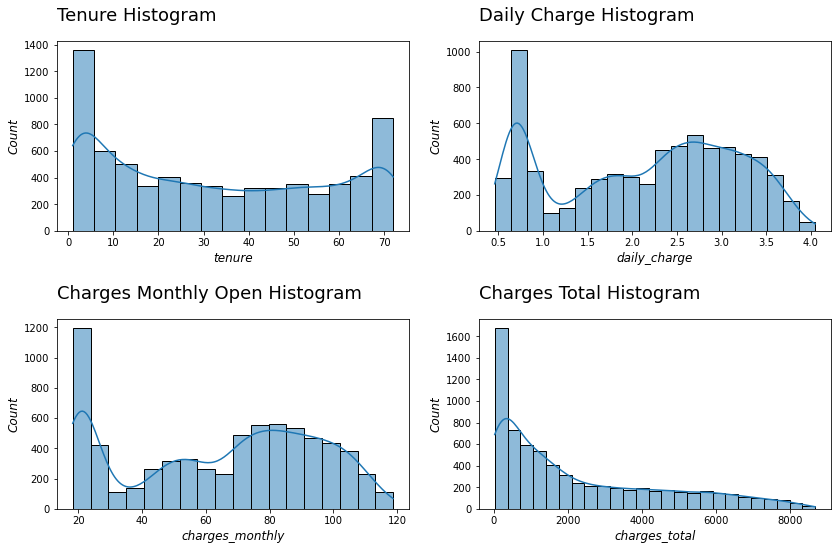

In [21]:
plt.figure(figsize=(12, 8), tight_layout={'pad': 2.0})

plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=num_att, x="tenure", kde=True)
std_font(ax1, 'Tenure Histogram',
         'tenure', 'Count')
plt.subplot(2, 2, 2)
ax2 = sns.histplot(data=num_att, x="daily_charge", kde=True)
std_font(ax2, 'Daily Charge Histogram', 'daily_charge', 'Count')
plt.subplot(2, 2, 3)
ax3 = sns.histplot(data=num_att, x="charges_monthly", kde=True)
std_font(ax3, 'Charges Monthly Open Histogram',
         'charges_monthly', 'Count')
plt.subplot(2, 2, 4)
ax4 = sns.histplot(data=num_att, x="charges_total", kde=True)
std_font(ax4, 'Charges Total Histogram', 'charges_total', 'Count')

# plt.show()

### 6.1.3 Categorical Variable

Dentre as distribuições das variáveis categóricas, notamos um balanceamento na feature gender, além de uma preferência dos clientes por pagamento em electronic check e quea maioria dos clientes estão cadastrados em planos mensais.

In [22]:
cat_att = df_clean.select_dtypes(exclude=['int64', 'float64'])

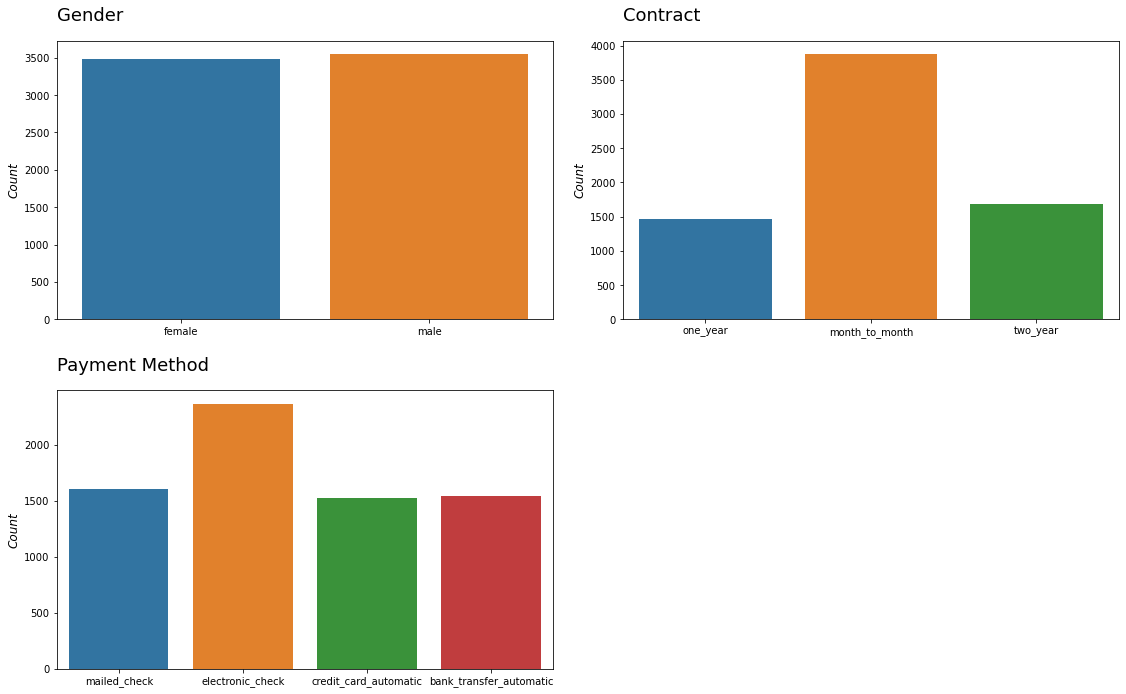

In [23]:
plt.figure(figsize=(16, 10), tight_layout={'pad':2.0})

# gender
plt.subplot( 2, 2, 1 )
ax1 = sns.countplot(x= cat_att['gender'] )
std_font(ax1, 'Gender',
         '', 'Count')

# contract
plt.subplot( 2, 2, 2 )
ax3 = sns.countplot( x=cat_att['contract'] )
std_font(ax3, 'Contract',
         '', 'Count')

# payment_method
plt.subplot( 2, 2, 3 )
ax5 = sns.countplot( x=cat_att['payment_method'] )
std_font(ax5, 'Payment Method',
         '', 'Count')


## 6.2 Bivariate Analysis

### 6.2.1 Quanto mais tempo de contrato o cliente tiver, menor a taxa de churn.

**VERDADEIRO** - Percebemos, de acordo com o gráfico, que quanto maior o tempo de contrato observamos uma tendência de redução na taxa de churn. Além disso, observamos também que a maior taxa de churn estão entre os clientes de até 5 anos. Com esta informação, o time de negócio já consegue tomar ações para reter esses clientes.

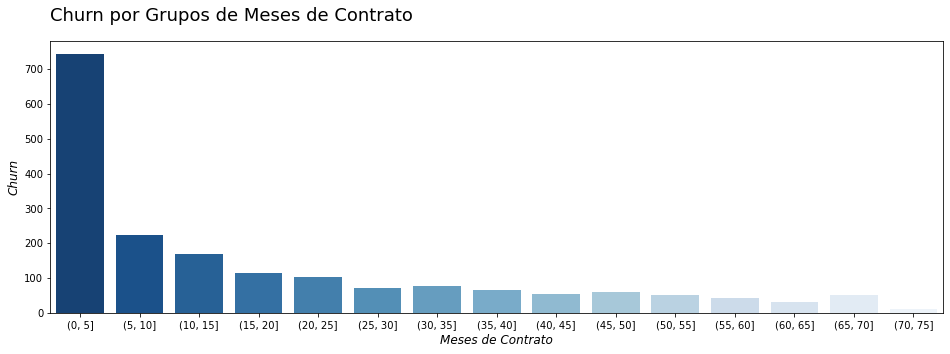

In [24]:
plt.figure(figsize=(16, 5))
bins = list( np.arange( 0, 80, 5) )

# plotando o tenure x tenure
aux = df_clean.query('churn == 1')
aux = aux[['tenure', 'churn']].groupby('tenure').count().reset_index()
aux['tenure_binned'] = pd.cut( aux['tenure'], bins=bins )
aux_bin = aux[['tenure_binned', 'churn']].groupby( 'tenure_binned' ).sum().reset_index()
ax1 = sns.barplot(data=aux_bin, x='tenure_binned', y='churn', palette='Blues_r')
std_font(ax1, 'Churn por Grupos de Meses de Contrato',
         'Meses de Contrato', 'Churn')

### 6.2.2 Mulheres tem maior probabilidade de entrar em churn.

**FALSO** - De acordo com a análise, vemos que dentre os clientes que entraram e churn, homens e mulheres têm a mesma proporção

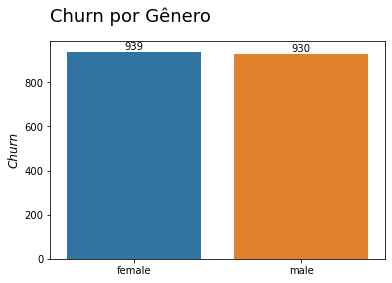

In [25]:
aux = df_clean.query('churn == 1')
aux = aux[['gender', 'churn']].groupby('gender').sum().reset_index()
ax1 = sns.barplot(data=aux, x='gender', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Gênero',
         '', 'Churn')

### 6.2.3 Clientes com dependentes tendem a ter menor taxa de churn

**VERDADEIRO** - Como podemos ver, 82% dos clientes que entram em churn têm o plano sem dependentes. Com esta informação, o time de negócios já consegue atuar desenvolvendo estratégias para incentivar clientes a aderirem aos planos com dependentes.

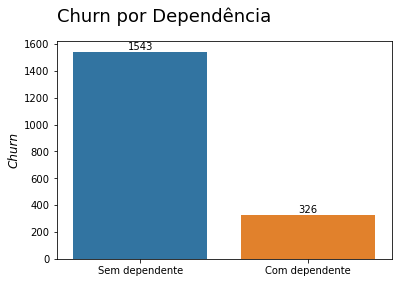

In [26]:
aux = df_clean.query('churn == 1')
aux = aux[['dependents', 'churn']].groupby('dependents').sum().reset_index()
aux['dependents'] = aux['dependents'].map({0: 'Sem dependente', 1:'Com dependente'})
ax1 = sns.barplot(data=aux, x='dependents', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Dependência',
         '', 'Churn')

### 6.2.4 A maioria dos clientes que entraram em churn não tinham suporte técnico

**VERDADEIRO** - Podemos ver que 83% dos clientes que entraram em churn não tinham suporte técnico. Isso mostra mais uma oportunidade para o time de negócio de tomar ações imediatas para reduzir o número de churn, oferecendo promoções e incentivos para que os clientes adquiram suporte técnico.

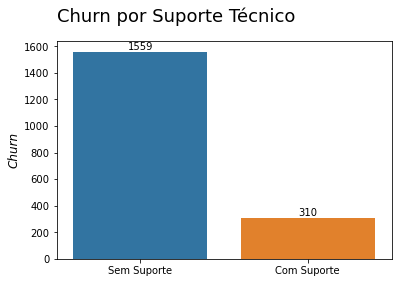

In [27]:
aux = df_clean.query('churn == 1')
aux = aux[['tech_support', 'churn']].groupby('tech_support').sum().reset_index()
aux['tech_support'] = aux['tech_support'].map({0: 'Sem Suporte', 1:'Com Suporte'})
ax1 = sns.barplot(data=aux, x='tech_support', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Suporte Técnico',
         '', 'Churn')

### 6.2.5 O meio de recebimento da fatura não tem influência na taxa de churn

**FALSO** - Notamos que há uma diferença considerável na taxa de churn, levando em consideração o meio de pagamento. Aqui percebemos algo inesperado: O meio de pagamento digital (que surge como uma proposta para melhorar a experiência do cliente) apresenta quase o triplo de churn em relação ao meio físico. Com essa informação, o time de negócios poderá atuar, junto com demais times, na identificação de problemas ou bugs no serviço de pagamento digital da empresa, visando diminuir esta taxa de churn.

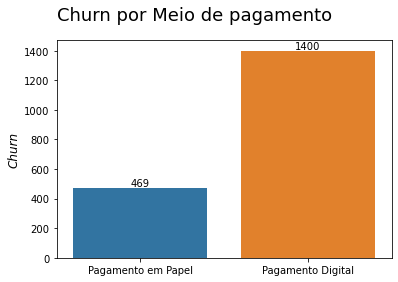

In [28]:
aux = df_clean.query('churn == 1')
aux = aux[['paperless_billing', 'churn']].groupby('paperless_billing').sum().reset_index()
aux['paperless_billing'] = aux['paperless_billing'].map({0: 'Pagamento em Papel', 1:'Pagamento Digital'})
ax1 = sns.barplot(data=aux, x='paperless_billing', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Meio de pagamento',
         '', 'Churn')

### 6.2.6 Clientes que tem assinatura de tv a cabo tem menores taxas de churn

**FALSO** - Observamos que na verdade os clientes com TV a cabo têm maiores taxas de churn. Porém, esta relação não é tao forte quanto as outras relações já observadas.

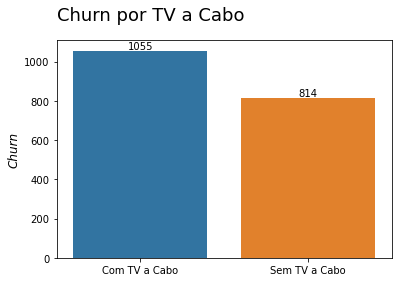

In [29]:
aux = df_clean.query('churn == 1')
aux = aux[['streaming_tv', 'churn']].groupby('streaming_tv').sum().reset_index()
aux['streaming_tv'] = aux['streaming_tv'].map({0: 'Com TV a Cabo', 1:'Sem TV a Cabo'})
ax1 = sns.barplot(data=aux, x='streaming_tv', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por TV a Cabo',
         '', 'Churn')

### 6.2.7 Clientes com gasto diário de mais de \$3 tendem a ter maior taxa de churn

**FALSO** - Há um pico de taxa de churn entre os valores diários de 2 a 3,5. Para entender este fenômeno, é preciso análises mais profundas junto ao time de negócio.

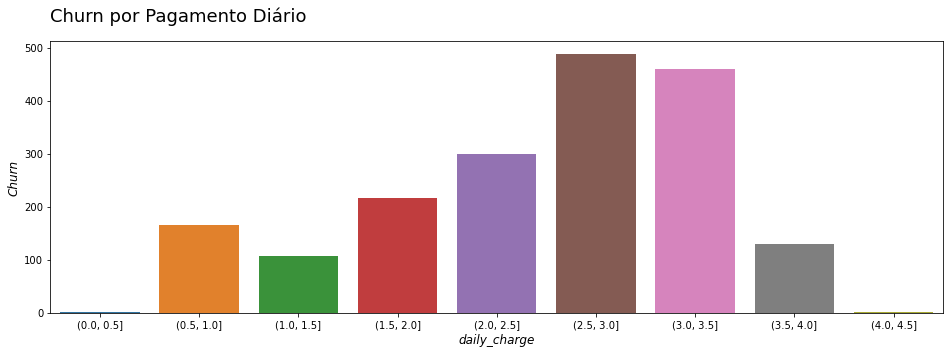

In [30]:
plt.figure(figsize=(16, 5))
bins = list( np.arange( 0, 5, 0.5) )

# plotando o tenure x tenure
aux = df_clean.query('churn == 1')
aux = aux[['daily_charge', 'churn']].groupby('daily_charge').count().reset_index()
aux['daily_binned'] = pd.cut( aux['daily_charge'], bins=bins )
aux_bin = aux[['daily_binned', 'churn']].groupby( 'daily_binned' ).sum().reset_index()
ax1 = sns.barplot(data=aux_bin, x='daily_binned', y='churn')
std_font(ax1, 'Churn por Pagamento Diário',
         'daily_charge', 'Churn')

### 6.2.8 Resumo das hipóteses

In [31]:
tab =[['Hipótese', 'Conclusão', 'Relevância', 'Descoberta'],
      ['H1', 'Verdadeiro', 'Alta', 'Quanto maior o tempo de contrato menor a taxa de churn.'],  
      ['H2', 'Falso', 'Média', 'Dentre os clientes que entraram e churn, homens e mulheres têm a mesma proporção.'],  
      ['H3', 'Verdadeiro', 'Alta', '18% dos clientes que entraram em churn têm dependentes.'],
      ['H4', 'Verdadeiro', 'Alta', '83% dos clientes que entraram em churn não tinham suporte técnico.'],
      ['H5', 'Falso', 'Média', 'Dentre os clientes que entraram em churn, 75% fazem uso do pagamento digital.'],
      ['H6', 'Falso', 'Baixa', 'Clientes com TV a cabo têm maiores taxas de churn, porém a diferença é de apenas 23%.'],
      ['H7', 'Falso', 'Baixa', 'Há um pico de taxa de churn entre os valores diários de 2 a 3,5.']    
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipótese    Conclusão    Relevância    Descoberta
----------  -----------  ------------  -------------------------------------------------------------------------------------
H1          Verdadeiro   Alta          Quanto maior o tempo de contrato menor a taxa de churn.
H2          Falso        Média         Dentre os clientes que entraram e churn, homens e mulheres têm a mesma proporção.
H3          Verdadeiro   Alta          18% dos clientes que entraram em churn têm dependentes.
H4          Verdadeiro   Alta          83% dos clientes que entraram em churn não tinham suporte técnico.
H5          Falso        Média         Dentre os clientes que entraram em churn, 75% fazem uso do pagamento digital.
H6          Falso        Baixa         Clientes com TV a cabo têm maiores taxas de churn, porém a diferença é de apenas 23%.
H7          Falso        Baixa         Há um pico de taxa de churn entre os valores diários de 2 a 3,5.


## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

 Dentre as variáveis numéricas, podemos observar que não há fortes correlações em relação a variável resposta. Porém, de acordo com a matriz de correlação, as variáveis que apresentaram as maiores correlações foram as variáveis de charge, paperless_billing, internet_service e tenure. Levaremos isso em consideração na hora de definir as features finais para o nosso modelo.

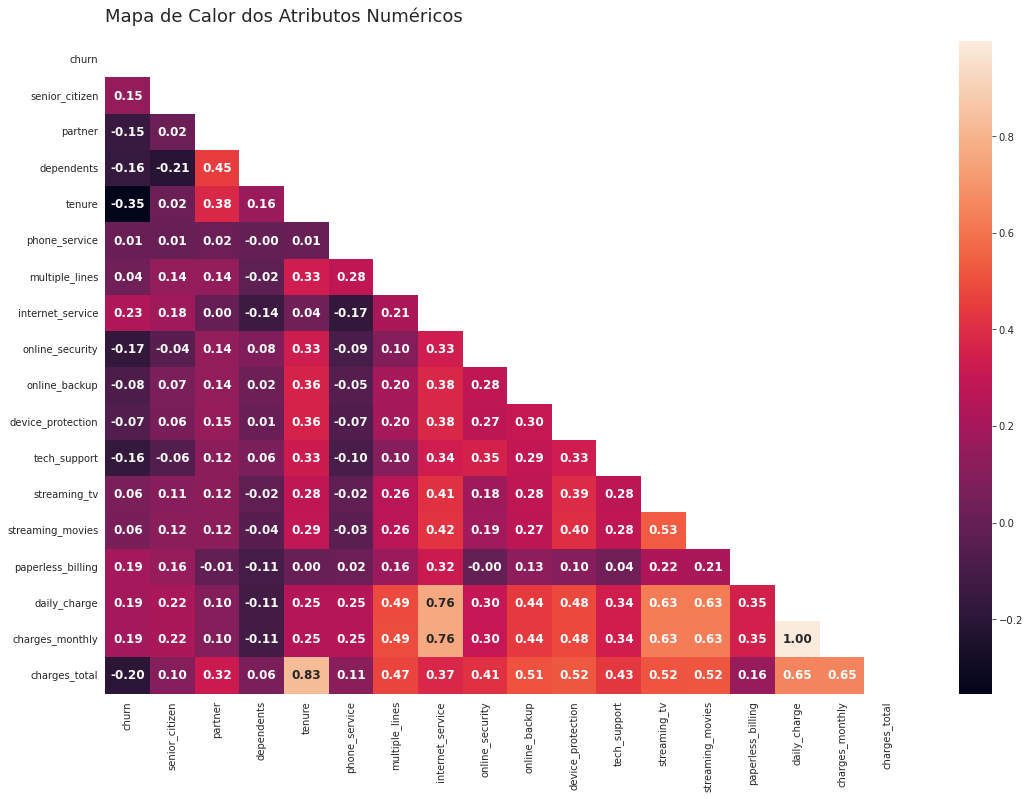

In [32]:
correlation = num_att.corr( method='pearson' )
plt.figure( figsize=(18, 12) )

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'}, mask=mask)
    std_font(ax1, 'Mapa de Calor dos Atributos Numéricos', '', '')

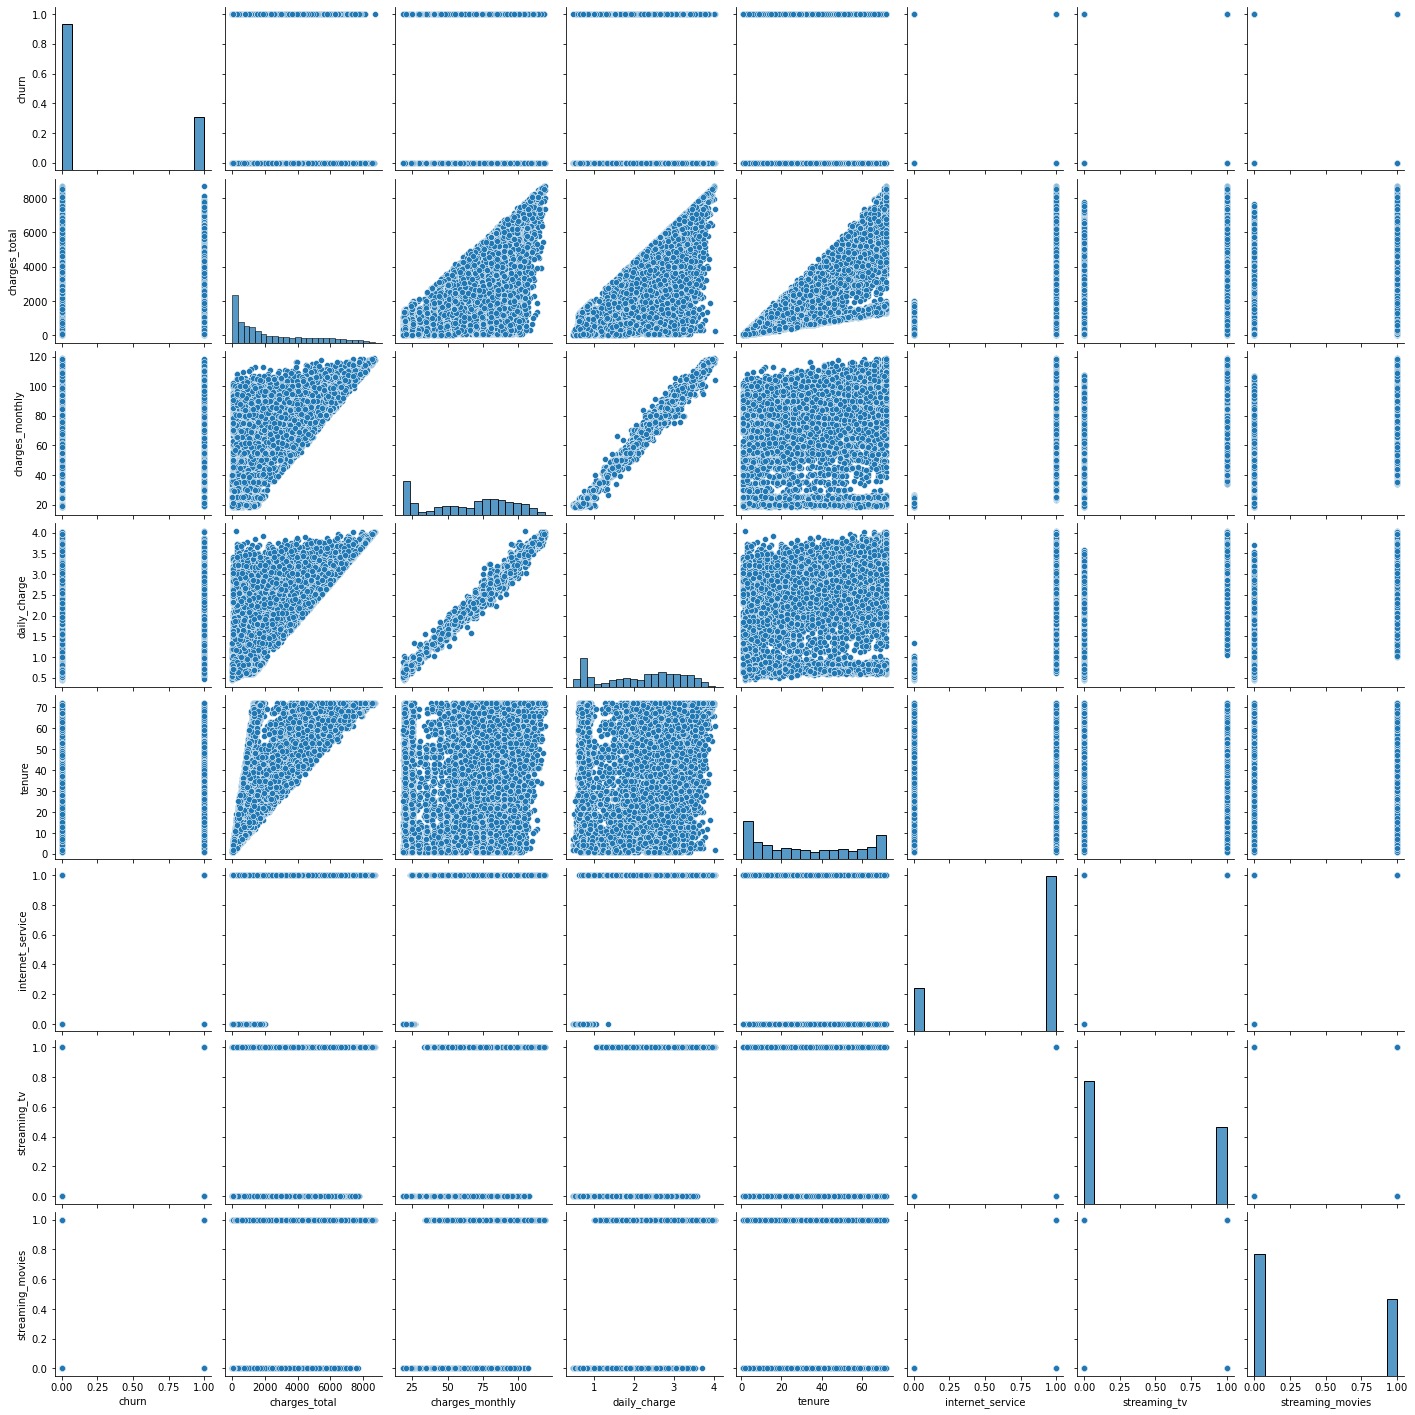

In [33]:
sns.pairplot(data=df_clean, vars=['churn', 'charges_total', 'charges_monthly', 'daily_charge',
                                  'tenure', 'internet_service', 'streaming_tv', 'streaming_movies'])

### 6.3.2 Categorical Attributes

Nesta seção utilizaremos a biblioteca pycorrcat para checar a correlação entre as features categóricas do nosso dataset:

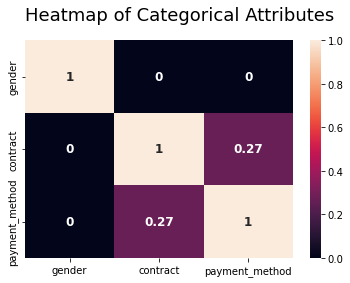

In [34]:
correlation_matrix = corr_matrix(cat_att,columns=['gender', 'contract', 'payment_method'])
ax1 = sns.heatmap(data=correlation_matrix, annot=True, annot_kws={'fontsize':12, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Categorical Attributes', '', '')

# 7 DATA PREPARATION

Para que o algoritmo desempenhe da melhor maneira possível, precisamos trazer todas as features para a mesma faixa de valores, para tanto, iremos aplicar uma normalização nos dados. Porém, antes de fazê-lo é de extrema importância que esta etapa seja feita nos grupos de treino e teste **SEPARADAMENTE**. Desta forma, vamos garantir que o modelo não aprenda com informações que não deveria, evitando assim um overfitting. 

In [35]:
df_norm = df_clean.drop(columns=['customer_id'])

# aplicando one hot encoding nas variáveis categóricas
df_norm = pd.get_dummies(df_norm, columns=['gender', 'contract', 'payment_method'], drop_first=True)

X = df_norm.drop(columns=['churn'])
y = df_norm['churn'].copy()

# # aplicando o undersampling
# rus = RandomUnderSampler(random_state=42)
# X, y = rus.fit_resample(X, y)

# aplicando o oversampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

In [36]:
# separando uma parte do dataset para teste final do modelo (mantendo a proporcao da variavel target)
X, X_test, y, y_test = ms.train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# separando o restante do dataset entre conjunto de treino de validacao (mantendo a proporcao da variavel target)
X_train, X_val, y_train, y_val = ms.train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

## 7.2 Normalization

In [37]:
# instanciando a nossa normalização
scaler = pp.StandardScaler()

## 7.3 Rescaling

## 7.4 Transformation

# 8 FEATURE SELECTION

## 8.1 Split dataframe into training and validation dataset

In [38]:
# model
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=1)

# applying model
X_train_n = X_train.copy()
y_train_n = y_train.values
forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

Feature Ranking: 
                                feature  importance
0                                tenure    0.130877
0                         charges_total    0.107860
0                          daily_charge    0.099365
0                       charges_monthly    0.099099
0                     contract_two_year    0.077553
0       payment_method_electronic_check    0.048999
0                     contract_one_year    0.044879
0                      internet_service    0.035334
0                           gender_male    0.034383
0                     paperless_billing    0.031616
0                          tech_support    0.030647
0                       online_security    0.028242
0                               partner    0.027476
0                         online_backup    0.025650
0                            dependents    0.024640
0                        senior_citizen    0.023462
0                        multiple_lines    0.023285
0                     device_protection    0.0

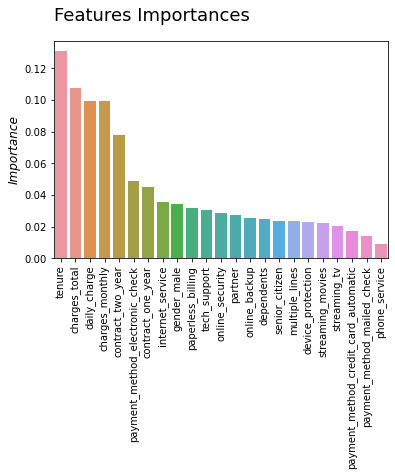

In [39]:
# the importance of each feature according to the model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


# Feature Ranking
print('Feature Ranking: ')
ranking = pd.DataFrame()
for i, j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    ranking = pd.concat([ranking,aux], axis=0)
    
print(ranking.sort_values('importance', ascending=False))

# plotting the feature importance
ax1 = sns.barplot(data=ranking.sort_values('importance', ascending=False), x='feature', y='importance' )
std_font(ax1, 'Features Importances', '', 'Importance')
plt.xticks( rotation=90 );

## 8.3 Selected Features

In [40]:
# selected_cols = list(ranking.sort_values('importance', ascending=False)['feature'][:4])
# selected_cols = ['tenure', 'charges_total', 'charges_monthly', 'payment_method_electronic_check',
#                  'contract_two_year', 'contract_one_year', 'tech_support', 'dependents',
#                  'paperless_billing']
selected_cols = list(ranking.sort_values('importance', ascending=False)['feature'])

X_train = X_train[selected_cols]
X_val = X_val[selected_cols]
X_test = X_test[selected_cols]
X = X[selected_cols]

# 9 MACHINE LEARNING MODELLING

## 9.1 Dummy Classifier

In [41]:
model_dummy = DummyClassifier(strategy='stratified', random_state=42)
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_dummy)])
pipeline.fit(X_train, y_train)
yhat_dummy = pipeline.predict(X_val)

# model_dummy.fit(X_train, y_train)
# yhat_dummy = model_dummy.predict(X_val)
df_dummy = model_metrics(y_val, yhat_dummy, 'Dummy')
df_dummy

,Model Name,Accuracy,Recall,Precision,F1
0,Dummy,0.499283,0.494978,0.499276,0.497118


## 9.2 KNN

In [42]:
model_knn = KNeighborsClassifier()
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_knn)])
pipeline.fit(X_train, y_train)
yhat_knn = pipeline.predict(X_val)

# model_knn.fit(X_train, y_train)
# yhat_knn = model_knn.predict(X_val)
df_knn = model_metrics(y_val, yhat_knn, 'KNN')
df_knn

,Model Name,Accuracy,Recall,Precision,F1
0,KNN,0.762554,0.868006,0.716825,0.785204


## 9.3 Logistic Regression

In [43]:
model_logistic = LogisticRegression()
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_logistic)])
pipeline.fit(X_train, y_train)
yhat_logistic = pipeline.predict(X_val)

# model_logistic.fit(X_train, y_train)
# yhat_logistic = model_logistic.predict(X_val)
df_logistic = model_metrics(y_val, yhat_logistic, 'Logistic Regression')
df_logistic

,Model Name,Accuracy,Recall,Precision,F1
0,Logistic Regression,0.769727,0.826399,0.742268,0.782077


## 9.4 SVM

In [44]:
model_svm = SVC(random_state=42)
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_svm)])
pipeline.fit(X_train, y_train)
yhat_svm = pipeline.predict(X_val)

# model_svm.fit(X_train, y_train)
# yhat_svm = model_svm.predict(X_val)
df_svm = model_metrics(y_val, yhat_svm, 'SVM')
df_svm

,Model Name,Accuracy,Recall,Precision,F1
0,SVM,0.781923,0.827834,0.758213,0.791495


## 9.5 Random Forest

In [45]:
model_random = RandomForestClassifier(random_state=42)
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_random)])
pipeline.fit(X_train, y_train)
yhat_random = pipeline.predict(X_val)

# model_random.fit(X_train, y_train)
# yhat_random = model_random.predict(X_val)
df_random = model_metrics(y_val, yhat_random, 'Random Forest')
df_random

,Model Name,Accuracy,Recall,Precision,F1
0,Random Forest,0.897418,0.964132,0.850633,0.903833


## 9.6 AdaBoost

In [46]:
model_ada = AdaBoostClassifier(random_state=42)
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_ada)])
pipeline.fit(X_train, y_train)
yhat_ada = pipeline.predict(X_val)

# model_ada.fit(X_train, y_train)
# yhat_ada = model_ada.predict(X_val)
df_ada = model_metrics(y_val, yhat_ada, 'AdaBoost')
df_ada


,Model Name,Accuracy,Recall,Precision,F1
0,AdaBoost,0.762554,0.813486,0.738281,0.774061


## 9.7 Resumo dos Modelos

In [47]:
pd.concat([df_ada, df_knn, df_logistic, df_svm, df_dummy, df_random]).sort_values('F1',ascending=False)

,Model Name,Accuracy,Recall,Precision,F1
0,Random Forest,0.897418,0.964132,0.850633,0.903833
0,SVM,0.781923,0.827834,0.758213,0.791495
0,KNN,0.762554,0.868006,0.716825,0.785204
0,Logistic Regression,0.769727,0.826399,0.742268,0.782077
0,AdaBoost,0.762554,0.813486,0.738281,0.774061
0,Dummy,0.499283,0.494978,0.499276,0.497118


# 10 CROSS-VALIDATION

In [48]:
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 10.1 KNN

In [49]:
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_knn)])
df_knn_cv = model_metrics_cv(pipeline, X, y, cv, 'KNN')
df_knn_cv

,Model Name,Accuracy,Recall,Precision,F1
0,KNN,0.764+/-0.014,0.863+/-0.014,0.721+/-0.018,0.785+/-0.01


## 10.2 Logistic Regression

In [50]:
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_logistic)])
df_logistic_cv = model_metrics_cv(pipeline, X, y, cv, 'Logistic Regression')
df_logistic_cv

,Model Name,Accuracy,Recall,Precision,F1
0,Logistic Regression,0.77+/-0.012,0.813+/-0.01,0.748+/-0.022,0.779+/-0.008


## 10.3 SVM

In [51]:
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_svm)])
df_svm_cv = model_metrics_cv(pipeline, X, y, cv, 'SVM')
df_svm_cv

,Model Name,Accuracy,Recall,Precision,F1
0,SVM,0.783+/-0.016,0.829+/-0.008,0.759+/-0.024,0.793+/-0.012


## 10.4 Random Forest

In [52]:
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_random)])
df_random_cv = model_metrics_cv(pipeline, X, y, cv, 'Random Forest')
df_random_cv

,Model Name,Accuracy,Recall,Precision,F1
0,Random Forest,0.887+/-0.008,0.935+/-0.006,0.852+/-0.012,0.892+/-0.008


## 10.5 AdaBoost

In [53]:
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_ada)])
df_ada_cv = model_metrics_cv(pipeline, X, y, cv, 'AdaBoost')
df_ada_cv

,Model Name,Accuracy,Recall,Precision,F1
0,AdaBoost,0.772+/-0.018,0.825+/-0.02,0.746+/-0.02,0.784+/-0.016


## 10.6 Resumo dos Modelos em Cross-Validation

In [54]:
pd.concat([df_ada_cv, df_knn_cv, df_logistic_cv, df_svm_cv, df_random_cv]).sort_values('F1',ascending=False)

,Model Name,Accuracy,Recall,Precision,F1
0,Random Forest,0.887+/-0.008,0.935+/-0.006,0.852+/-0.012,0.892+/-0.008
0,SVM,0.783+/-0.016,0.829+/-0.008,0.759+/-0.024,0.793+/-0.012
0,KNN,0.764+/-0.014,0.863+/-0.014,0.721+/-0.018,0.785+/-0.01
0,AdaBoost,0.772+/-0.018,0.825+/-0.02,0.746+/-0.02,0.784+/-0.016
0,Logistic Regression,0.77+/-0.012,0.813+/-0.01,0.748+/-0.022,0.779+/-0.008


# 11 HYPERPARAMETER FINE TUNNING

## 11.1 Grid Search

In [55]:
# pipeline = Pipeline([('transformacao', scaler), ('estimador',model_random)])
# parametros= {
#     'estimador__n_estimators' : [100, 140, 180, 220, 260],
#     'estimador__criterion' : ['gini', 'entropy', 'log_loss'],
#     'estimador__max_depth' : [None, 5, 10, 15, 20, 25]
# }

# busca = GridSearchCV(pipeline, parametros, cv=cv)
# busca.fit(X,y)

# # means = busca.cv_results_['mean_test_score']
# # stds = busca.cv_results_['std_test_score']
# # params = busca.cv_results_['params']
# # for mean, stdev, param in zip(means, stds, params):
# #     print("%f (%f) with: %r" % (mean, stdev, param))
    
# resultados = pd.DataFrame(busca.cv_results_)
# resultados.head(3)

In [56]:
# print('Parâmetros usados: ',busca.best_params_)
# print('Acurácia: ',busca.best_score_)

# >>> Parâmetros usados:  {'estimador__criterion': 'gini', 'estimador__max_depth': 25, 'estimador__n_estimators': 260}
# >>> Acurácia:  0.8704411842194405

## 11.2 Final Model

In [57]:
model_random = RandomForestClassifier(n_estimators=260, criterion='gini', max_depth=25, random_state=42)
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_random)])
df_random_cv = model_metrics_cv(pipeline, X, y, cv, 'Random Forest')
df_random_cv

,Model Name,Accuracy,Recall,Precision,F1
0,Random Forest,0.885+/-0.01,0.935+/-0.014,0.85+/-0.014,0.891+/-0.01


# 12 BUSINESS PERFORMANCE

## 12.1 Performance Final do Modelo com Dados de Teste

In [58]:
model_random = RandomForestClassifier(n_estimators=260, criterion='gini', max_depth=25, random_state=42)
pipeline = Pipeline([('transformacao', scaler), ('estimador',model_random)])
pipeline.fit(X, y)
yhat_random = pipeline.predict(X_test)

df_random = model_metrics(y_test, yhat_random, 'Random Forest')
df_random

,Model Name,Accuracy,Recall,Precision,F1
0,Random Forest,0.89545,0.953488,0.854167,0.901099


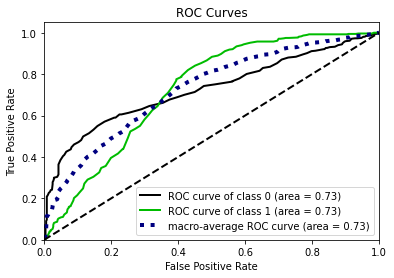

<Figure size 864x720 with 0 Axes>

In [59]:
y_probas = model_random.predict_proba(X_test.to_numpy())
skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False)
plt.figure(figsize=(12,10))
plt.show()


# 13 NEXT STEPS